In [77]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings('ignore')
import dtale

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  StandardScaler

from itertools import product
from pandas_profiling import ProfileReport
from prince import MCA

%config InlineBackend.figure_format = 'retina'

# Seeting seaborn style
sns.set()

from datetime import datetime
import calendar
import missingno as msno
from sklearn.impute import SimpleImputer
import scipy.stats as ss
from sklearn.decomposition import PCA

In [2]:
alldata = pd.read_csv ("/Users/vsa/Documents/DM/data/donors.csv", low_memory=False)
data = alldata.copy()

In [3]:
#data = alldata[['DOB', 'ODATEDW', 'FISTDATE', 'LASTDATE', 'ADATE_2', 'TCODE',
#               'GENDER', 'NGIFTALL']]

## Working with subsets of columns, coherence check

In the beginning we decided to add to our analysis the most important columns from our point of view:
- Age (calculate from DOB column), Months from the first gift, Months from the last gift, Recency/Frequency/Amount, Income, Gender...


Section with filling NaNs will be after this one, but we will impute some NaN values during data transformation in this part.
We will begin to add some most important features one by one.

#### Important Datetime columns ODATEDW, FISTDATE, LASTDATE, ADATE_2, DOB and their transformation

In [4]:
# Print sum on NaNs in these columns:
print ('Number of Nans in ODATEDW', data.ODATEDW.isna().sum())
print ('Number of Nans in FISTDATE', data.FISTDATE.isna().sum())
print ('Number of Nans in LASTDATE', data.LASTDATE.isna().sum())

Number of Nans in ODATEDW 0
Number of Nans in FISTDATE 2
Number of Nans in LASTDATE 0


In [5]:
# Convert columns 'DOB' and ADATE_2 to datetime
data.DOB = pd.to_datetime(data.DOB)
data.ADATE_2 = pd.to_datetime(data.ADATE_2)

# Convert LASTDATE to datetime
data.LASTDATE = pd.to_datetime(data.LASTDATE)

# Convert ODATEDW to datetime
data.ODATEDW = pd.to_datetime(data.ODATEDW)

# Convert FISTDATE to datetime
data.FISTDATE = pd.to_datetime(data.FISTDATE)

Before calculating Age - let's check coherence in mentioned columns:
ODATEDW, FISTDATE, LASTDATE, ADATE_2 and DOB in the end.

From metadafata file - ODATEDW and FISTDATE have the same meaning:
ODATEDW - Date of donor's first gift to PVA YYMM format (Year/Month) and FISTDATE - Date of first gift,
so we will choose more compliant column with other columns to work with.

In [6]:
# All columns except FISTDATE and DOB do not have NaNs, 
# we will impute NaNs in FISTDATE with values from ODATEDW, as these two columns have the same meaning
# Impute NaNs for 'FISTDATE'using values from ODATEDW
data['FISTDATE'].fillna(data['ODATEDW'], inplace = True)
data['FISTDATE'].isna().sum()

0

In [7]:
# Calculate amount of months from the last day LASTDATE, ODATEDW and FISTDATE
# and ADATE_2 - Date the latest promotion was sent 
# (the number of months between dates are calculating on the moment of ADATE_2 
# as was discussed during Q&A and at Project Forum)

# Calculate number of months from ADATE_2 for each column
data ['ODATEDW_MONTHS'] = (data.ADATE_2 - data.ODATEDW).astype('timedelta64[M]')
data ['LASTDATE_MONTHS'] = (data.ADATE_2 - data.LASTDATE).astype('timedelta64[M]') 
data ['FIRSTDATE_MONTHS'] = (data.ADATE_2 - data.FISTDATE).astype('timedelta64[M]')

In [8]:
# Checking for inconsistencies between LASTDATE_MONTHS and FIRSTDATE_MONTHS
inconsist = (len(data [data ['LASTDATE_MONTHS'] > data['FIRSTDATE_MONTHS']]))
print('Number of inconsistencies between LASTDATE_MONTHS and FIRSTDATE_MONTHS:', inconsist)

Number of inconsistencies between LASTDATE_MONTHS and FIRSTDATE_MONTHS: 0


In [9]:
# Checking for inconsistencies between LASTDATE_MONTHS and ODATEDW_MONTHS
inconsist = (len(data [data ['LASTDATE_MONTHS'] > data['ODATEDW_MONTHS']]))
print('Number of inconsistencies between LASTDATE_MONTHS and ODATEDW_MONTHS:', inconsist)
print('Percentage of inconsistencies between LASTDATE_MONTHS and ODATEDW_MONTHS:', inconsist/len(data)*100)

# The percentage of inconsistencies in ODATEDW_MONTHS is quite high - 3.8 %
# So we have two columns with the same meaning:
# ODATEDW (Date of donor's first gift to PVA YYMM format (Year/Month) and FISTDATE (Date of first gift)

# and one of them (ODATEDW) is inconsistent with others - we are not going to use this column

Number of inconsistencies between LASTDATE_MONTHS and ODATEDW_MONTHS: 3627
Percentage of inconsistencies between LASTDATE_MONTHS and ODATEDW_MONTHS: 3.8014086278455537


So we have two columns with the same meaning:
- ODATEDW (Date of donor's first gift to PVA YYMM format (Year/Month) 
- FISTDATE (Date of first gift).

And one of them (ODATEDW) is inconsistent with others - we are not going to use this column

Checking for incontsistancies between date of first gift of a donor and his/her birhday date

In [10]:
# Date of donor's first gift to PVA
# cannot be earlier than his/her Date of Birthday (DOB)

# From metadafata file - ODATEDW and FISTDATE have the same meaning:
# ODATEDW Date of donor's first gift to PVA YYMM format (Year/Month) and FISTDATE Date of first gift

# We use strict '<' not '<=' , thinking that some parents in the day of birth of his child 
#could do first donation on behalf of this child to PVA
print ('Number of inconsistencies between ODATEDW and DOB', len(data[data.ODATEDW < data.DOB]))

Number of inconsistencies between ODATEDW and DOB 304


In [11]:
# Same checking for FISTDATE
print ('Number of inconsistencies between FISTDATE and DOB', len(data[data.FISTDATE < data.DOB]))
print ('Percentage of inconsistencies between FISTDATE and DOB', 
       round(len(data.loc[data.FISTDATE < data.DOB])/len(data)*100, 2))

Number of inconsistencies between FISTDATE and DOB 278
Percentage of inconsistencies between FISTDATE and DOB 0.29


In [12]:
# Checking if these inconsistencies in both columns intersect
# (If they were not - we could use information from one column to fill other one)
len(data[(data.FISTDATE < data.DOB)&(data.ODATEDW < data.DOB)])

277

As we see inconsistencies in them match, so we cannnot improve data in any of them in this case.
And as ODATEDW showed itself as less compliant column from both ODATEDW and FISTDATE,
we will not use it in our analysis

In [13]:
# Drop ODATEDW and ODATEDW_MONTHS as not needed anymore
data.drop(columns = ['ODATEDW','ODATEDW_MONTHS'], inplace = True)

In [14]:
# As per result from previous cells: Number of inconsistencies between FISTDATE and DOB 278
# With such small percent (0.29%) of inconsistent rows - we are going to drop these rows 
indexNames = (data[data.FISTDATE < data.DOB]).index
data.drop(indexNames , inplace=True)

In [15]:
# Checking for inconsistencies in DOB and ADATE_2
# assuming that DOB (date of birthday) can't be after ADATE_2

print ('Number of inconsistencies between ADATE_2 and DOB:', len(data[data.ADATE_2 < data.DOB]))

Number of inconsistencies between ADATE_2 and DOB: 0


Before continuing our work with DOB column - 
we want to to see the full picture with missing values in columns that we are going to use:
    - DOB, INCOME, GENDER, WEALTH1 and WEALTH2.
Are they missing at random or maybe we can find some pattern in missing data:

In [16]:
# We replace ' ' in our Gender column with NaNs
# to better understand pattern of missing values
data.GENDER = data.GENDER.replace(' ', np.nan)
print ('Number of missing values in Gender column', data.GENDER.isna().sum())

Number of missing values in Gender column 2947


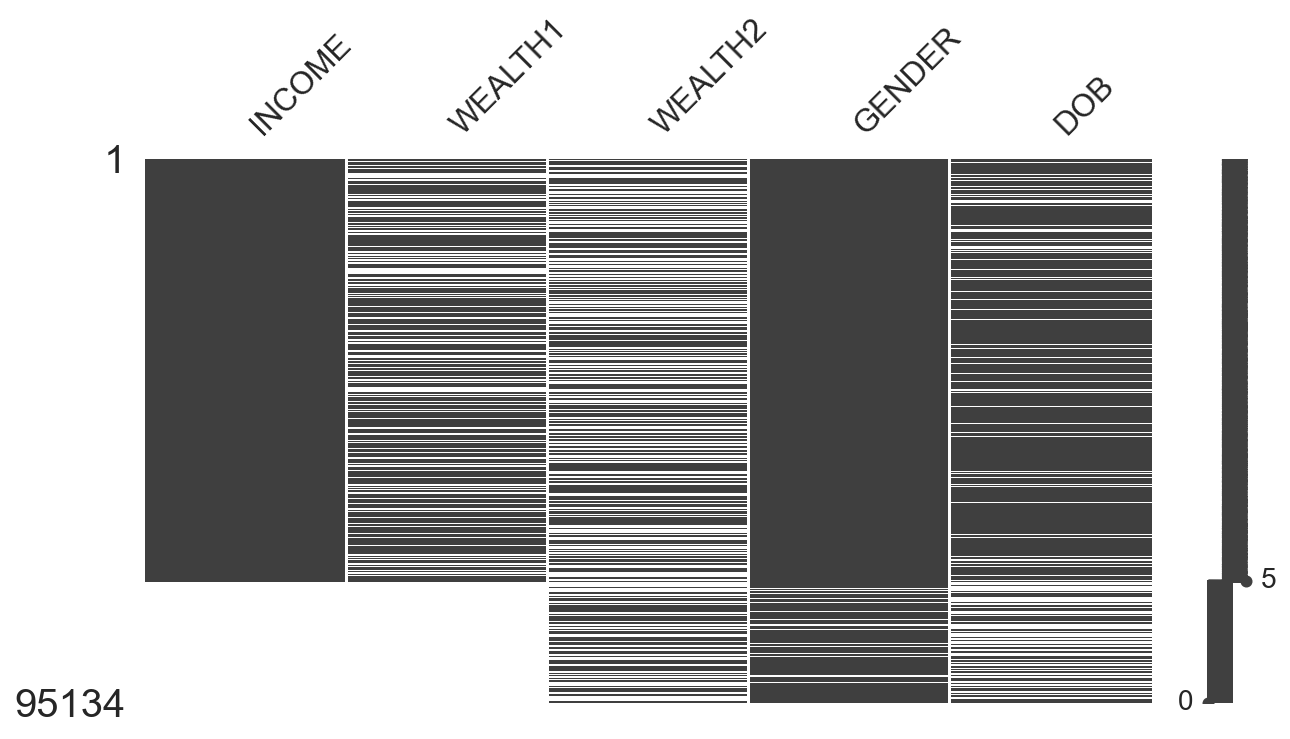

In [17]:
# Let's check whether we have a pattern in mising values 

wealth_features = ['INCOME','WEALTH1','WEALTH2','GENDER','DOB' ]
%matplotlib inline
sorted_data = data[wealth_features].sort_values('INCOME')
msno.matrix(sorted_data, figsize=(10, 5))
plt.show()

As we can see from missingno analysis - it looks that only NaN values in WEALTH2 from chosen columns 
look like missing at random (MAR),  but all other have a pattern and are missing not at random (MNAR).
We have missing values in Gender when we have NaNs in WEALTH2 and INCOME. NaNs in Income correspond NaNs in WEALTH1.

In [18]:
# Let's check what percentage of our data is missing at the same time in all 
# columns that we have chosen as important for our ananlysis
print('Amount of rows with Nans in DOB and GENDER and INCOME:', 
      len(data[(data.DOB.isna())&(data.GENDER.isna())&(data.INCOME.isna())]))

Amount of rows with Nans in DOB and GENDER and INCOME: 1767


We are goint to drop these particular rows, where we have NaNs at the same time, imputing missing values for other

In [19]:
indexNames = (data[(data.DOB.isna())&(data.GENDER.isna())&(data.INCOME.isna())]).index
data.drop(indexNames , inplace=True)

In [20]:
# Print percentage of droped data comparing to initial dataset from 95412 rows
print('The percentage of droped data comparing to initial dataset:',
     round((95412 - len(data))/95412*100,2))

The percentage of droped data comparing to initial dataset: 2.14


#### AGE column

In [21]:
# Here we calculate age as it was discussed during Q&A session:
# 'Calculate age on the moment of ADATE_2, paying attention that ADATE_2 has 2 different values in a column:
# 2017-06-01 (95399 instances), 2017-04-01 (13 instances)'

data["AGE"] = (data.ADATE_2 - data.DOB).astype('timedelta64[Y]')
print('Nmber of Nans in AGE', data['AGE'].isna().sum())

Nmber of Nans in AGE 22116


,count,mean,std,min,25%,50%,75%,max
AGE,71251.0,58.70872,16.459463,4.0,46.0,59.0,73.0,87.0


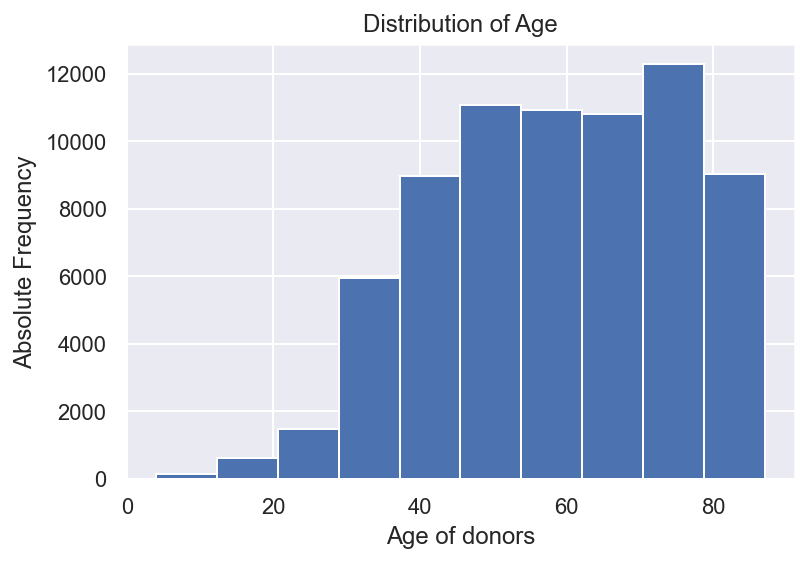

In [22]:
# Let's build distribution plot for Age column, that has for now near 23-24K NaNs
# Build histogram for Age column
data["AGE"].hist(bins = 10)
plt.title('Distribution of Age')
plt.xlabel('Age of donors')
plt.ylabel('Absolute Frequency')
stats = data['AGE'].describe().to_frame().T
stats

In [23]:
# KNNImputer - impute NaNs in Age column 
# using columns AGE901 and AGE904 with median and average age for people's neighbourhood,
# where AGE901 - Median Age of Population in a neighbourhood, 
# AGE904 - Average Age of Population in a neighbourhood
imputer = KNNImputer(n_neighbors=5, weights="uniform")
age_features = ['AGE','AGE901', 'AGE904']
data[age_features] = imputer.fit_transform(data[age_features])

#Round the values down in AGE column because KNN produces floats
data['AGE'] = data['AGE'].apply(np.floor).astype('float')

,count,mean,std,min,25%,50%,75%,max
AGE,93367.0,58.487346,14.90919,4.0,48.0,59.0,70.0,87.0


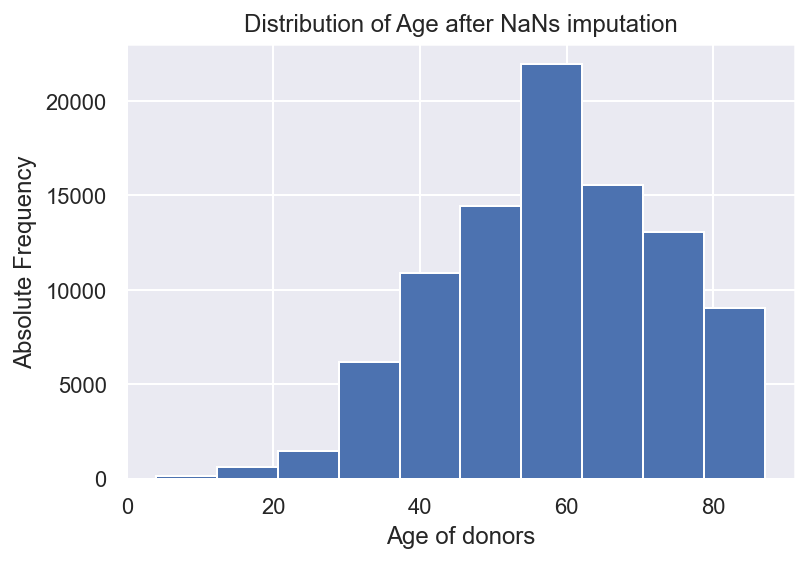

In [24]:
# Build histogram for imputed Age column
data["AGE"].hist(bins = 10)
plt.title('Distribution of Age after NaNs imputation')
plt.xlabel('Age of donors')
plt.ylabel('Absolute Frequency')
stats = data['AGE'].astype('float').describe().to_frame().T
stats

After NaNs imputation our Age distribution is looks more like Normal Distribution as it was before

#### Recency/Frequency/Amount columns, 
#### and comparing some datetime columns and inconsistencies to choose best to work with

In [25]:
# Next we will create and fill out column 'RECENCY' based on information from metadata file
# to find inconsistencies as per forum all donors should be lapsed

# F=FIRST TIME DONOR Anyone who has made their first donation in the last 6 months and has
# made just one donation.
    
# N=NEW DONOR Anyone who has made their first donation in the last 12 months and is not a First time donor. 
# This is everyone who made their first donation 7-12 months ago, or
# people who made their first donation between 0-6 months ago and have made 2 or more donations.
    
# A=ACTIVE DONOR Anyone who made their first donation more than 12 months ago and has made
# a donation in the last 12 months.
    
# L=LAPSING DONOR A previous donor who made their last donation between 13-24 months ago.
    
# I=INACTIVE DONOR A previous donor who has not made a donation in the last 24 months. 
# It is people who made a donation 25+ months ago.

Let's find out all these groups of donors and create 'RECENCY' column

#### Create column with the Recency, using an abreviation from metadata file (F, N, A, L, I donors)

From the Project Forum:
- You can assume RFA_2R is the correct one since the donors in the dataset are supposed to be lapsed ones. The lapsed donors in this dataset are determined according to the date the last promotion (17NK) was emailed to each one of them and the date of their most recent gift. Inconsistent observations are the ones which have an interval between these two dates smaller than 13 months
- This dataset is supposed to be composed only by lapsed donors. Maybe we weren't very explicit on this but PVA is particularly interested on this segment of customers, hence the data being only from this segment. The observations you found are actually inconsistencies. You should deal with them somehow and provide an explanation on how you did it.
https://elearning.novaims.unl.pt/moodle/mod/forum/discuss.php?d=6304


In [26]:
data['RECENCY']= ''
# Print Lapsed donours (that made their last donation to PVA 13 to 24 months ago )

print('Number of lapsed donors donors:')
print(len(data [(data ['LASTDATE_MONTHS'] >=13.0)& (data ['LASTDATE_MONTHS'] <= 24.0)]))
data.loc[(data['LASTDATE_MONTHS'] >= 13.0)& (data['LASTDATE_MONTHS'] <= 24.0), 'RECENCY'] = 'L'

Number of lapsed donors donors:
82309


In [27]:
#  Print number of FIRST TIME DONOR donours (F=FIRST TIME DONOR Anyone who has made their first donation 
# in the last 6 months and has and has made just one donation.)

print('Number of first time donors donors:')
print(len(data [(data['FIRSTDATE_MONTHS'] <= 6.0) & ((data['NGIFTALL'] == 1))]))
data.loc[(data['FIRSTDATE_MONTHS'] <= 6.0) & (data['NGIFTALL'] == 1), 'RECENCY'] = 'F'

Number of first time donors donors:
0


In [28]:
# N = NEW DONOR Anyone who has made their first donation in the last 12 months and is not a First time donor.  
# This is everyone who made their first donation 7-12 months ago, or
# people who made their first donation between 0-6 months ago and have made 2 or more donations.

print('Number of new donors:')
print(len(data.loc[(data['FIRSTDATE_MONTHS'] <= 12.0) & (data['RECENCY'] != 'F') ]))

data.loc[(data['FIRSTDATE_MONTHS'] <= 12.0) & (data['RECENCY'] != 'F') ] = 'N'


Number of new donors:
0


In [29]:
# I=INACTIVE DONOR A previous donor who has not made a donation in the last 24 months.  
# It is people who made a donation 25+ months ago.
print('Number of inactive donors:')
print(len(data.loc[(data['LASTDATE_MONTHS'] >= 25.0)&(data['FIRSTDATE_MONTHS'] >= 25.0)]))

data.loc[(data['LASTDATE_MONTHS'] >= 25.0)&(data['FIRSTDATE_MONTHS'] >= 25.0), 'RECENCY'] = 'I'

Number of inactive donors:
7173


In [30]:
# A=ACTIVE DONOR Anyone who made their first donation more than 12 months ago 
# and has made a donation in the last 12 months.

print('Number of active donors:')
print(len(data.loc[(data['FIRSTDATE_MONTHS'] >= 12.0) & (data['LASTDATE_MONTHS'] < 12.0)]))

data.loc[(data['FIRSTDATE_MONTHS'] >= 12.0) & (data['LASTDATE_MONTHS'] < 12.0), 'RECENCY'] = 'A'

Number of active donors:
3885


Despite fact that we should have only Lapsed donors in our dataset
we have only 82309 lapsed, inactive - 7173  and active 3885.

So we have 11.8 % of inconsistancies - donors that should be lapsed because of RFA_2 'L'
but they are inactive or active

In [31]:
# Print number of re-calculated donors that are not lapsed at the moment of last promotion ADATE_2
print('Number of not lapsed donors', len(data.loc[data.RECENCY != 'L']))
print('Percentage of not lapsed donors', len(data.loc[data.RECENCY != 'L'])/len(data)*100)

Number of not lapsed donors 11058
Percentage of not lapsed donors 11.843584992556258


##### So we have 11.8% of not lapsed donors in dataset that should consist only from lapsed ones. We can't drop such amount of data 

Professor at forum:
    You can assume RFA_2R is the correct one since the donors in the dataset are supposed to be lapsed ones.   
    The observations you found are actually inconsistencies. 
    You should deal with them somehow and provide an explanation on how you did it.
    
At QandAnswers session they say completely different - to calculate these Recency all by ourselves, and decide for these few rows - but there are not few rows, it is 12 percent there 

So we are going to explore all these groups paying more attention to 'true' lapsed donors

In [32]:
# Create Frequency and Amount columns for RFA analysis, using RFA_2 columns
data['FREQUENCY'] = data.RFA_2F
data['AMOUNT'] = data.RFA_2A

In [33]:
data['FREQUENCY'].value_counts()

1    46662
2    20124
3    14964
4    11617
Name: FREQUENCY, dtype: int64

In [34]:
data['AMOUNT'].value_counts()

F    45975
E    21209
G    18980
D     7203
Name: AMOUNT, dtype: int64

#### 'INCOME' column: imputation using 'wealth'-related columns

Now we will continue with INCOME, WEALTH1 and WEALTH2 - categorical columns, each one of them has a lot of NaNs:
    - WEALTH1 - 44,625 NaNs
    - WEALTH2 - 43,813 NaNs
    - INCOME - 21228 NaNs
We are going to impute these columns and use only INCOME column for our further analysis.

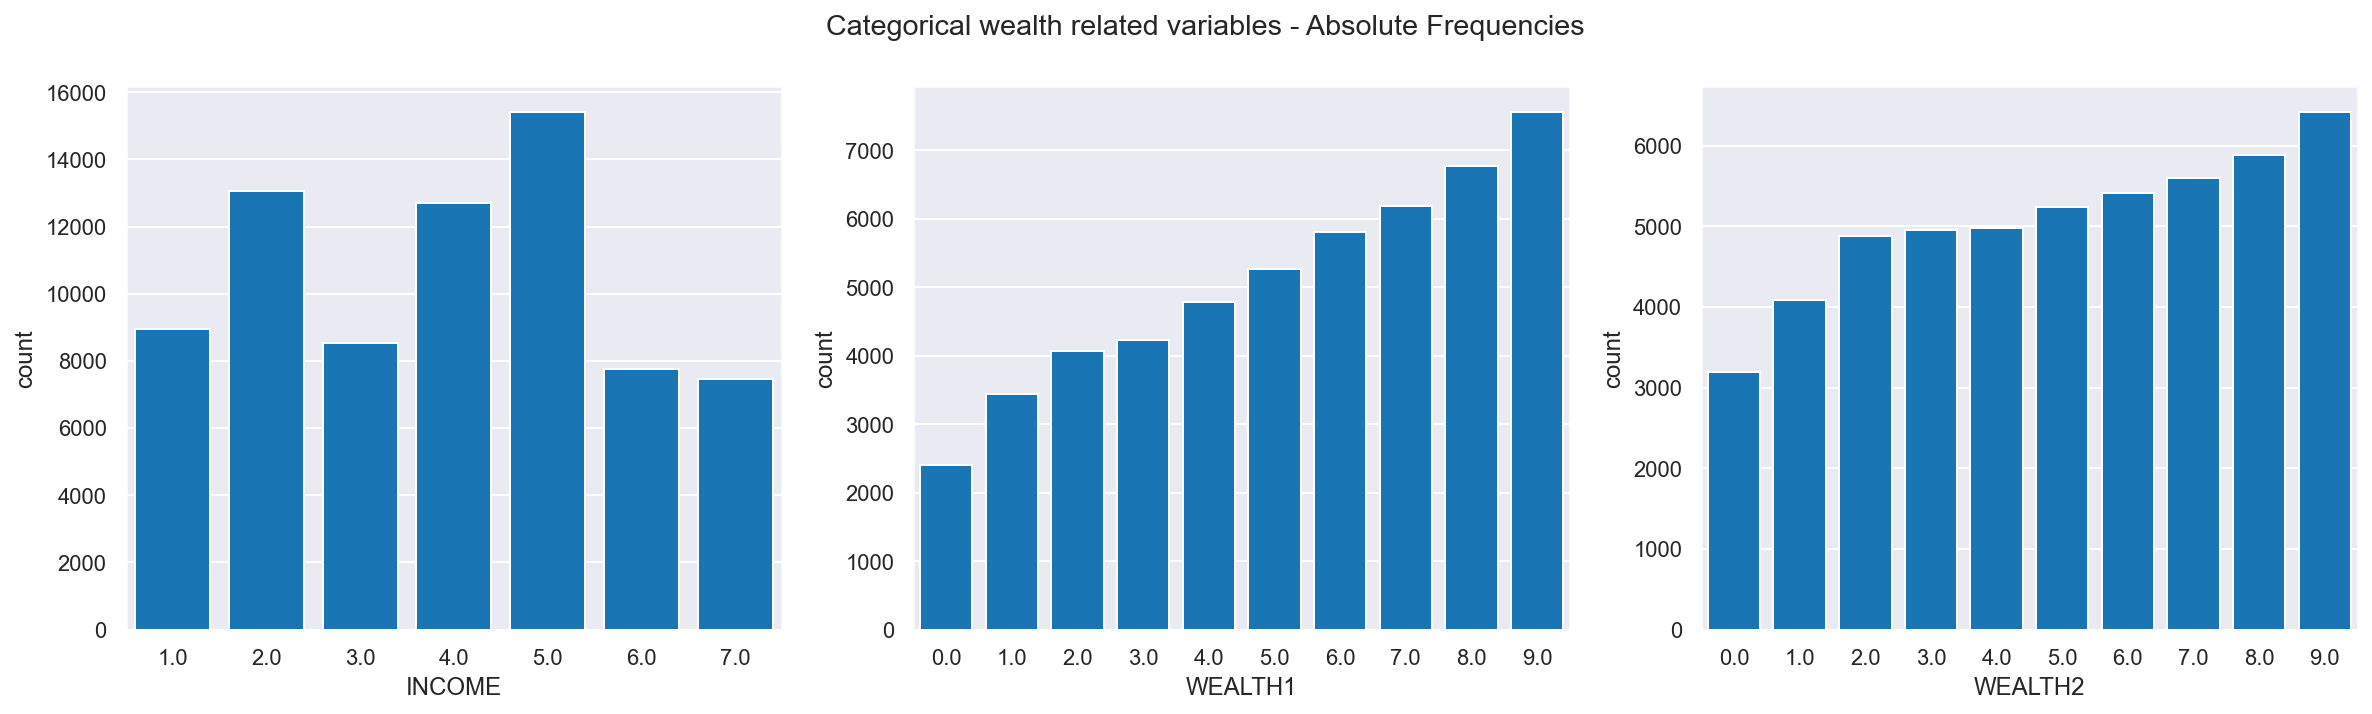

In [35]:
# Explore wealth-related categorical columns values
sns.set()

wealth_features = ['INCOME','WEALTH1','WEALTH2']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), wealth_features): 
    sns.countplot(data[feat].sort_values(), 
                  ax=ax, color='#007acc')

title = "Categorical wealth related variables - Absolute Frequencies"
plt.suptitle(title)
plt.show()

In [36]:
# Impute data in WEALTH related columns,
# where INCOME, WEALTH1, WEALTH2 - categorical variables,
# IC1 - Median Household Income in hundreds (2010 US Census)
# AGE - age column

wealth_features = ['INCOME','WEALTH1','WEALTH2', 'AGE', 'IC1']

# Scale variables before imputation
scaler = MinMaxScaler()

data_impute = data[wealth_features].copy()

# Scale AGE and IC1
data_impute[["AGE", "IC1"]] = pd.DataFrame(scaler.fit_transform(data_impute[["AGE", "IC1"]]), index = data.index)

In [37]:
# Use KNN Imputer to impute missing variables from 1 nearest neighbour
# (only 1 because we work with categorical data and we should not find 'mean' in this case)
imputer = KNNImputer(n_neighbors=1)
data_impute = pd.DataFrame(imputer.fit_transform(data_impute), 
                           columns = data_impute.columns,
                           index = data_impute.index)

In [38]:
# Copy imputed columns to initial dataframe we work with data
data[['INCOME','WEALTH1','WEALTH2']] = data_impute[['INCOME','WEALTH1','WEALTH2']].astype('int')

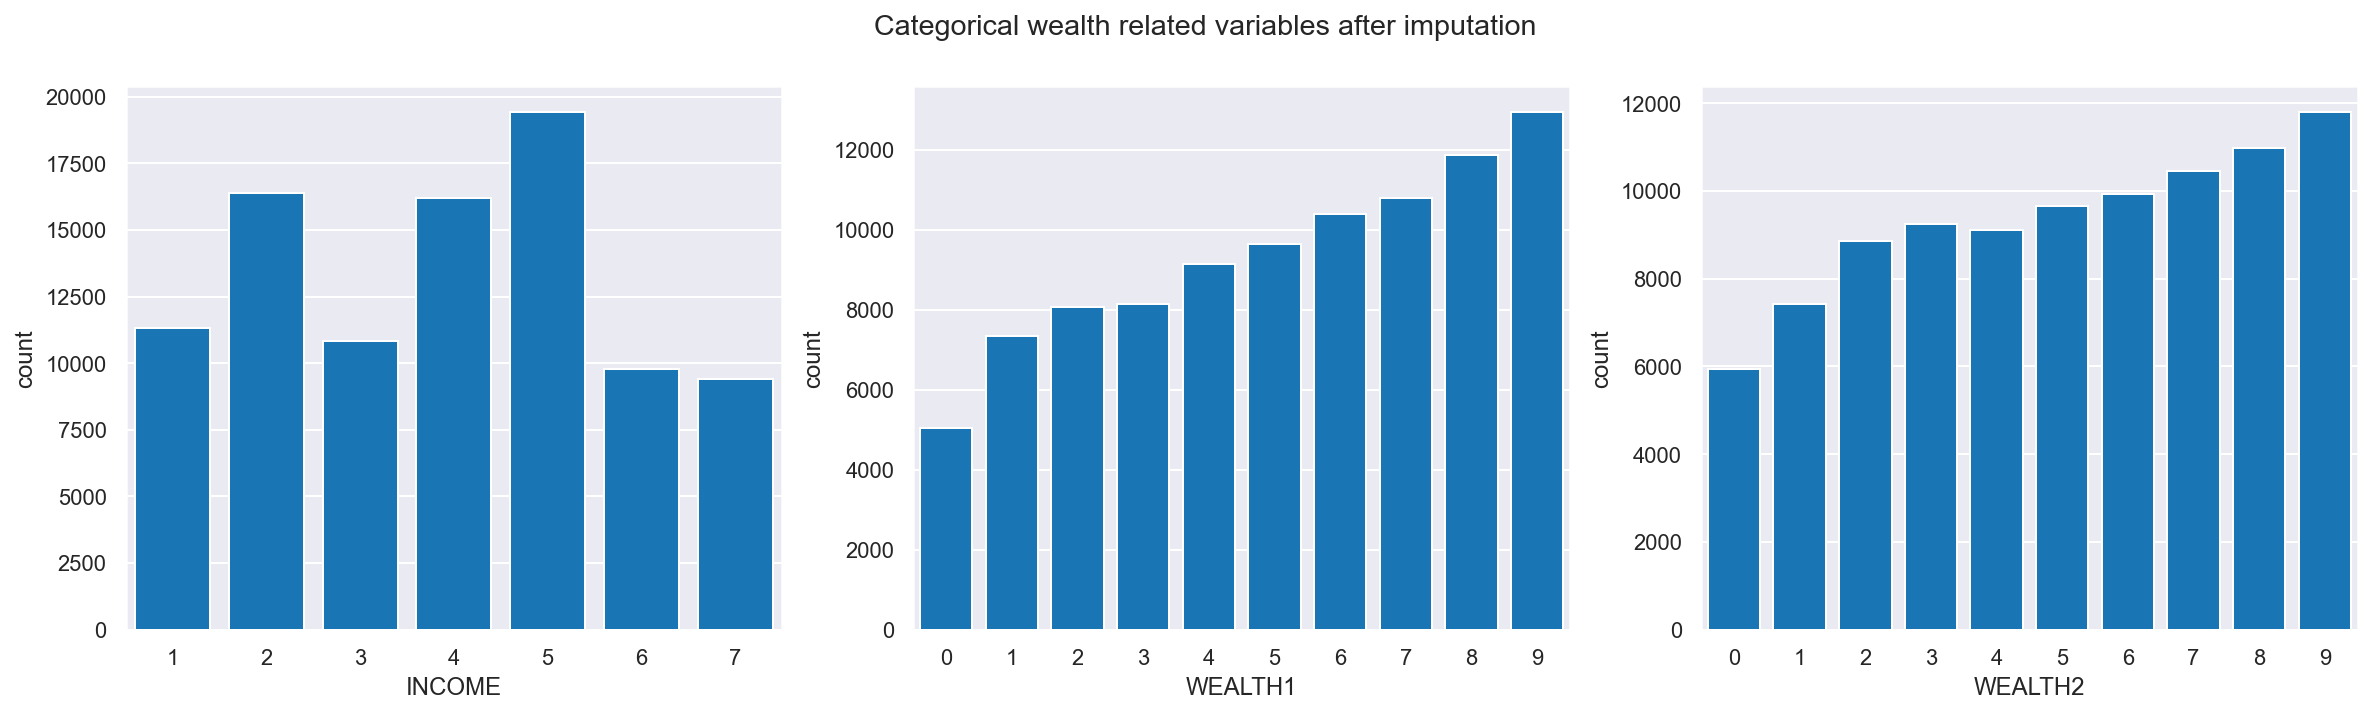

In [39]:
# Explore wealth-related categorical columns values
sns.set()

wealth_features = ['INCOME','WEALTH1','WEALTH2']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), wealth_features): 
    sns.countplot(data[feat].sort_values(), 
                  ax=ax, color='#007acc')

title = "Categorical wealth related variables after imputation"
plt.suptitle(title)
plt.show()

We have same distribution of values after imputation, as it was before imputation

#### Gender column

# remark to team: Not sure about gender encoding
Do we need leave joint accounts or not be left in 'gender', because it changes boolen variable (0 or 1 for gender) to categorical one, and it is only 364 Joint accounts in dataset, other - Unknown or NaNs (that techniaclly are also unknown).
I encode these joint accounts (J = Joint Account, unknown gender) as nans, but this could be changed

In [40]:
len(data.loc[(data.GENDER == "J")])

364

In [41]:
# Let's decode Gender column's values
# From metadata file M = Male, F = Female, U = Unknown, J = Joint Account, unknown gender
# not forgeting about 4 rows with values 'A', 'C'

data.loc[(data.GENDER == "M"), 'GENDER'] = '1'
data.loc[(data.GENDER == "F"), 'GENDER'] = '0'
# data.loc[(data.GENDER == "J"), 'GENDER'] = '3'

# We assume that these letters 'J','U','A','C'- Unknown values equal to NaNs
data.loc[(data.GENDER == "J") | (data.GENDER == "U")|(data.GENDER == "A")|(data.GENDER == "C"), 'GENDER'] = ' '

# Convert column to numeric
data.GENDER = pd.to_numeric(data.GENDER, errors='coerce')

In [42]:
print ('Number of NaNs in Gender:', data.GENDER.isna().sum())
data['GENDER'].value_counts()

Number of NaNs in Gender: 3257


0.0    51119
1.0    38991
Name: GENDER, dtype: int64

In [43]:
# Impute NaNs in Gender column using most frequent value
data['GENDER'] = data['GENDER'].replace(np.nan, data['GENDER'].mode()[0]).astype('int')
# data.GENDER = data.GENDER.astype('bool')


#### TCODE column exploration is added in the end of notebook

#### Domain

In [44]:
# FAD
domainCats = [
    letter + str(i) for i in range(1, 4) for letter in ["U", "C", "S", "T", "R"]
]

data["cat_FAD_domain"] = pd.Categorical(data.DOMAIN, categories=domainCats, ordered=False)
data.cat_FAD_domain

0        T2
1        S1
2        R2
3        R2
4        S2
         ..
95407    C2
95408    C1
95409    C3
95410    C1
95411    C1
Name: cat_FAD_domain, Length: 93367, dtype: category
Categories (15, object): [U1, C1, S1, T1, ..., C3, S3, T3, R3]

In [45]:
# Save all data
data.to_csv("project_data_after_imputation.csv", index = False)

### Main part

From now on we have the features that we founf most important for our analysis
an are going to continue with only them, adding some other from data dataset if needed

In [46]:
data = pd.read_csv ("project_data_after_imputation.csv", low_memory=False)

In [47]:
features = ['cat_FAD_domain', 'STATE', 'AGE', 'INCOME', 'WEALTH2', 'GENDER', 'RECENCY', 'FREQUENCY', 'AMOUNT', 'RAMNTALL', 
            'NGIFTALL', 'LASTGIFT', 'AVGGIFT', 'LASTDATE_MONTHS', 'FIRSTDATE_MONTHS']
data_fin = data[features].copy().reset_index(drop=True)

In [60]:
metric_features = ['AGE','RAMNTALL', 'NGIFTALL',  'AVGGIFT','LASTDATE_MONTHS', 'FIRSTDATE_MONTHS']

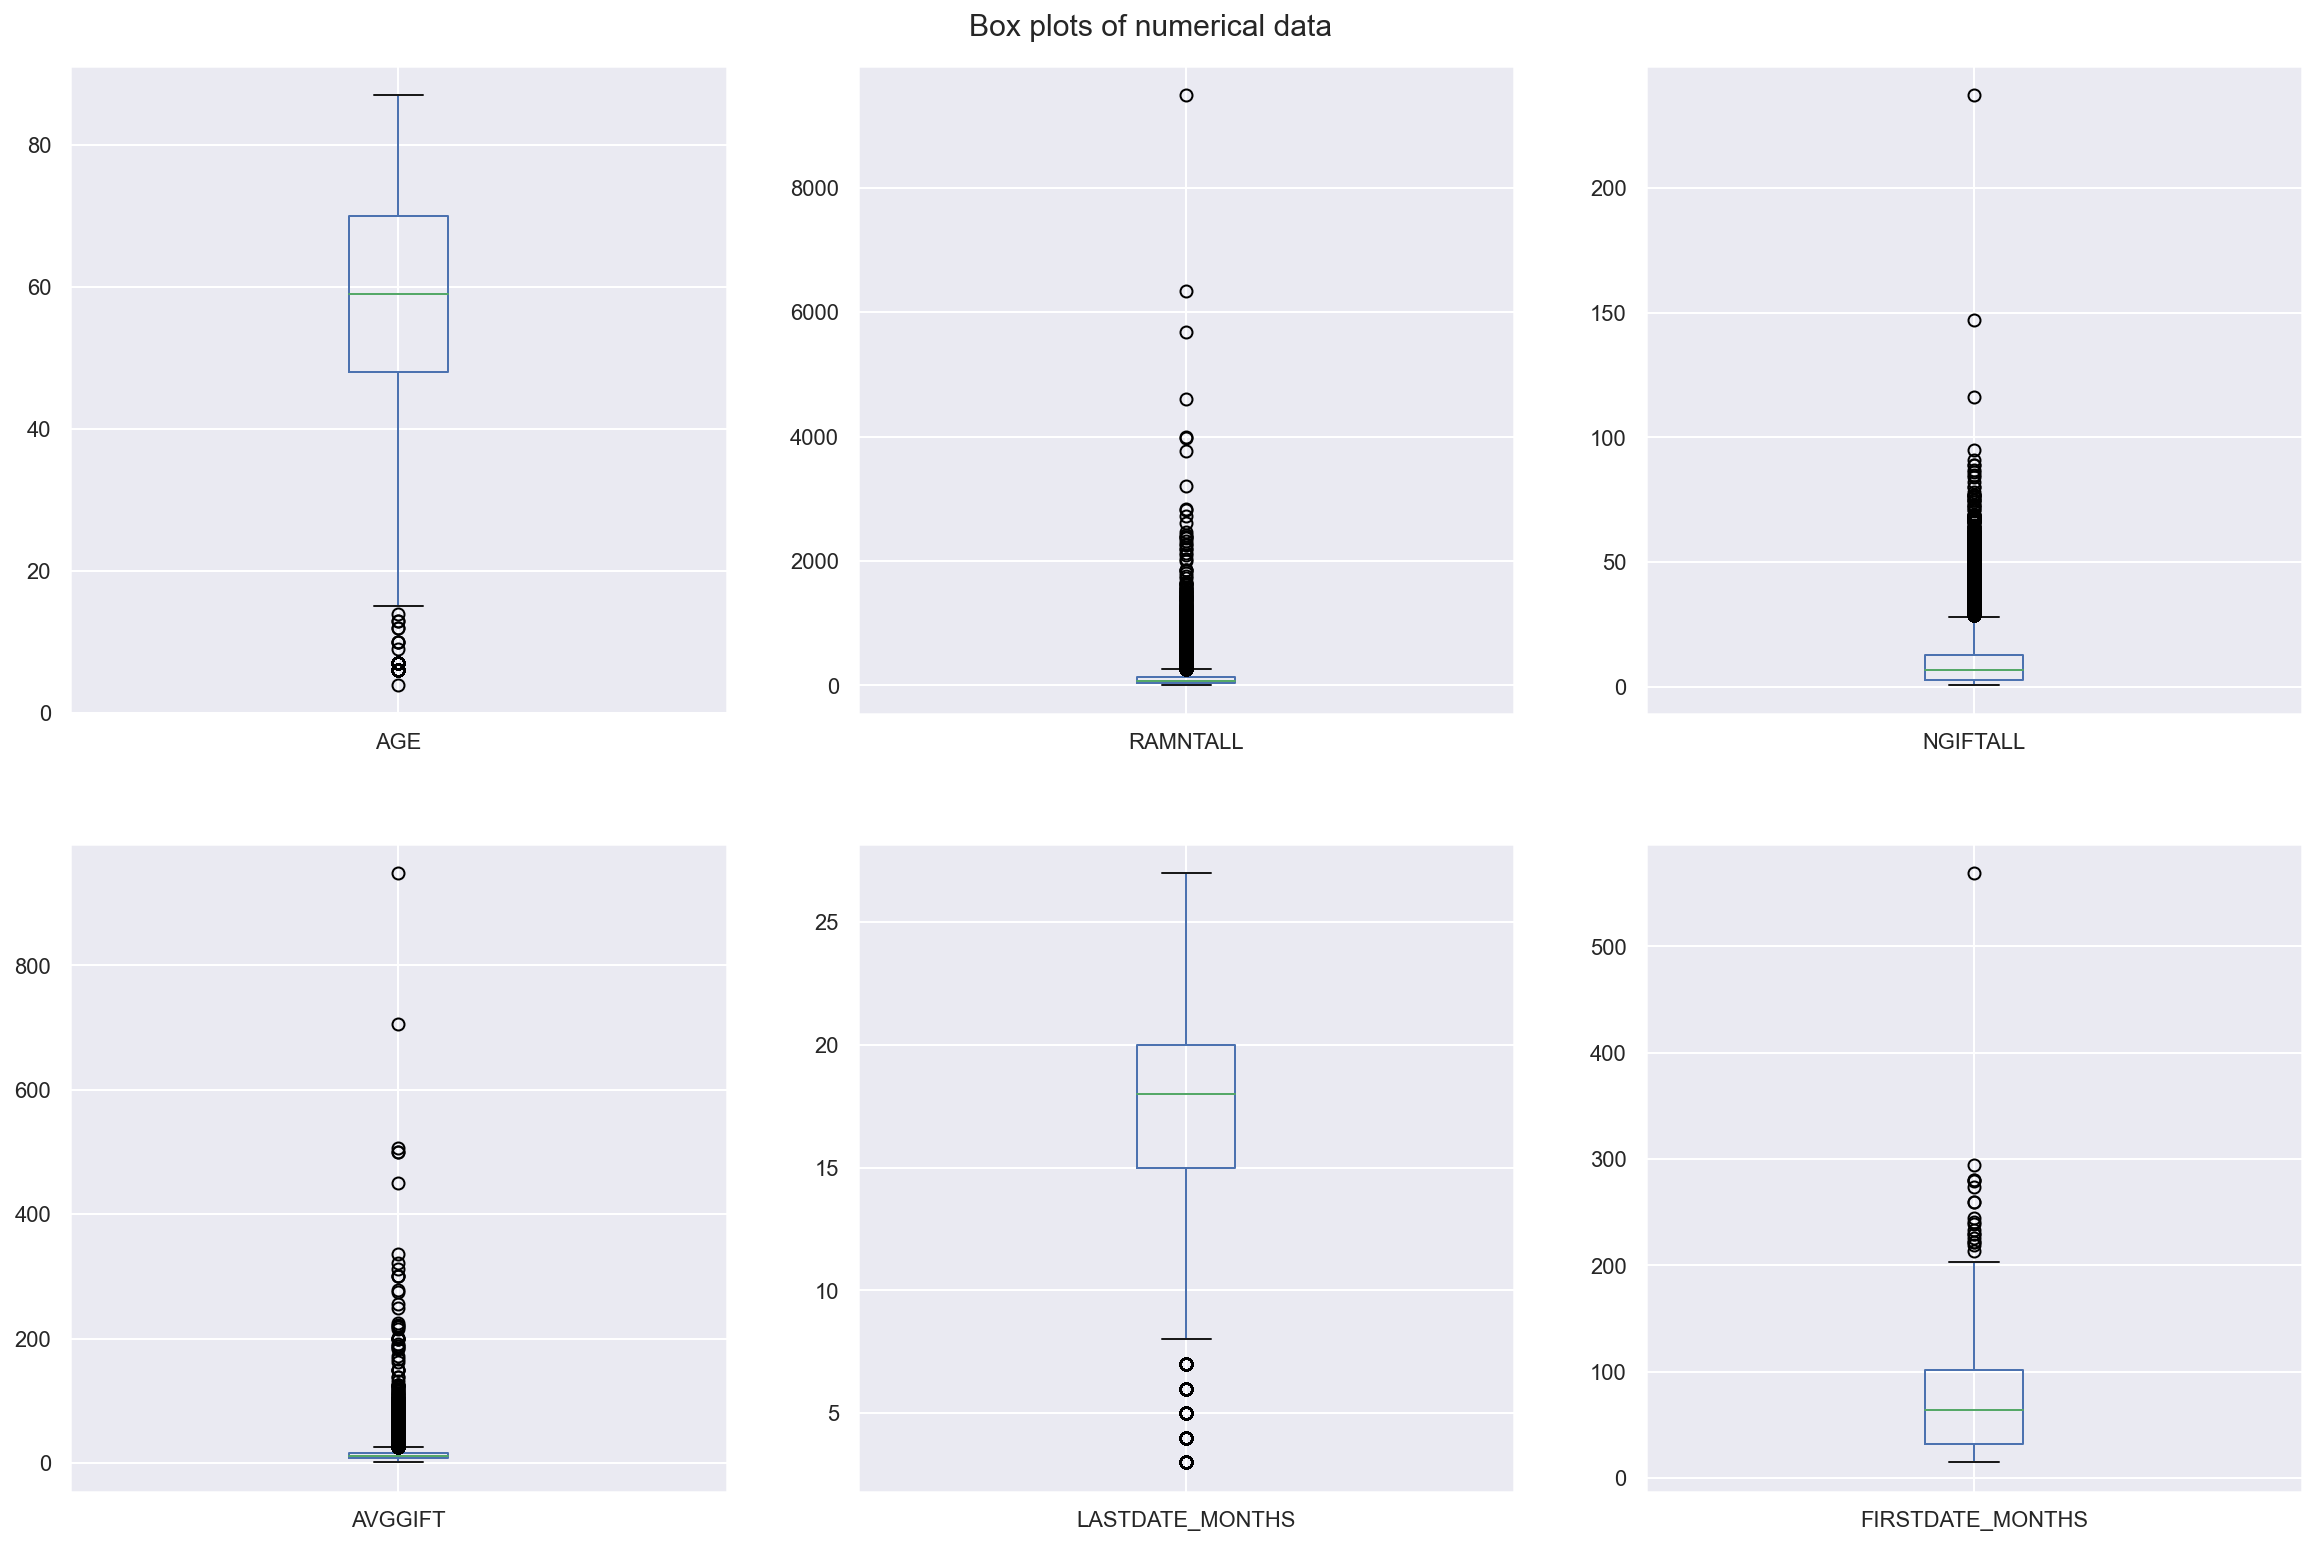

In [61]:
# box and whisker plots
sns.set()

# set box plot and layout
data_fin[metric_features].plot(kind='box', subplots=True, layout=(2,3), figsize=(20,12), sharex=False, sharey=False)
plt.subplots_adjust(top=0.95)
plt.suptitle("Box plots of numerical data", fontsize=15)

plt.show()

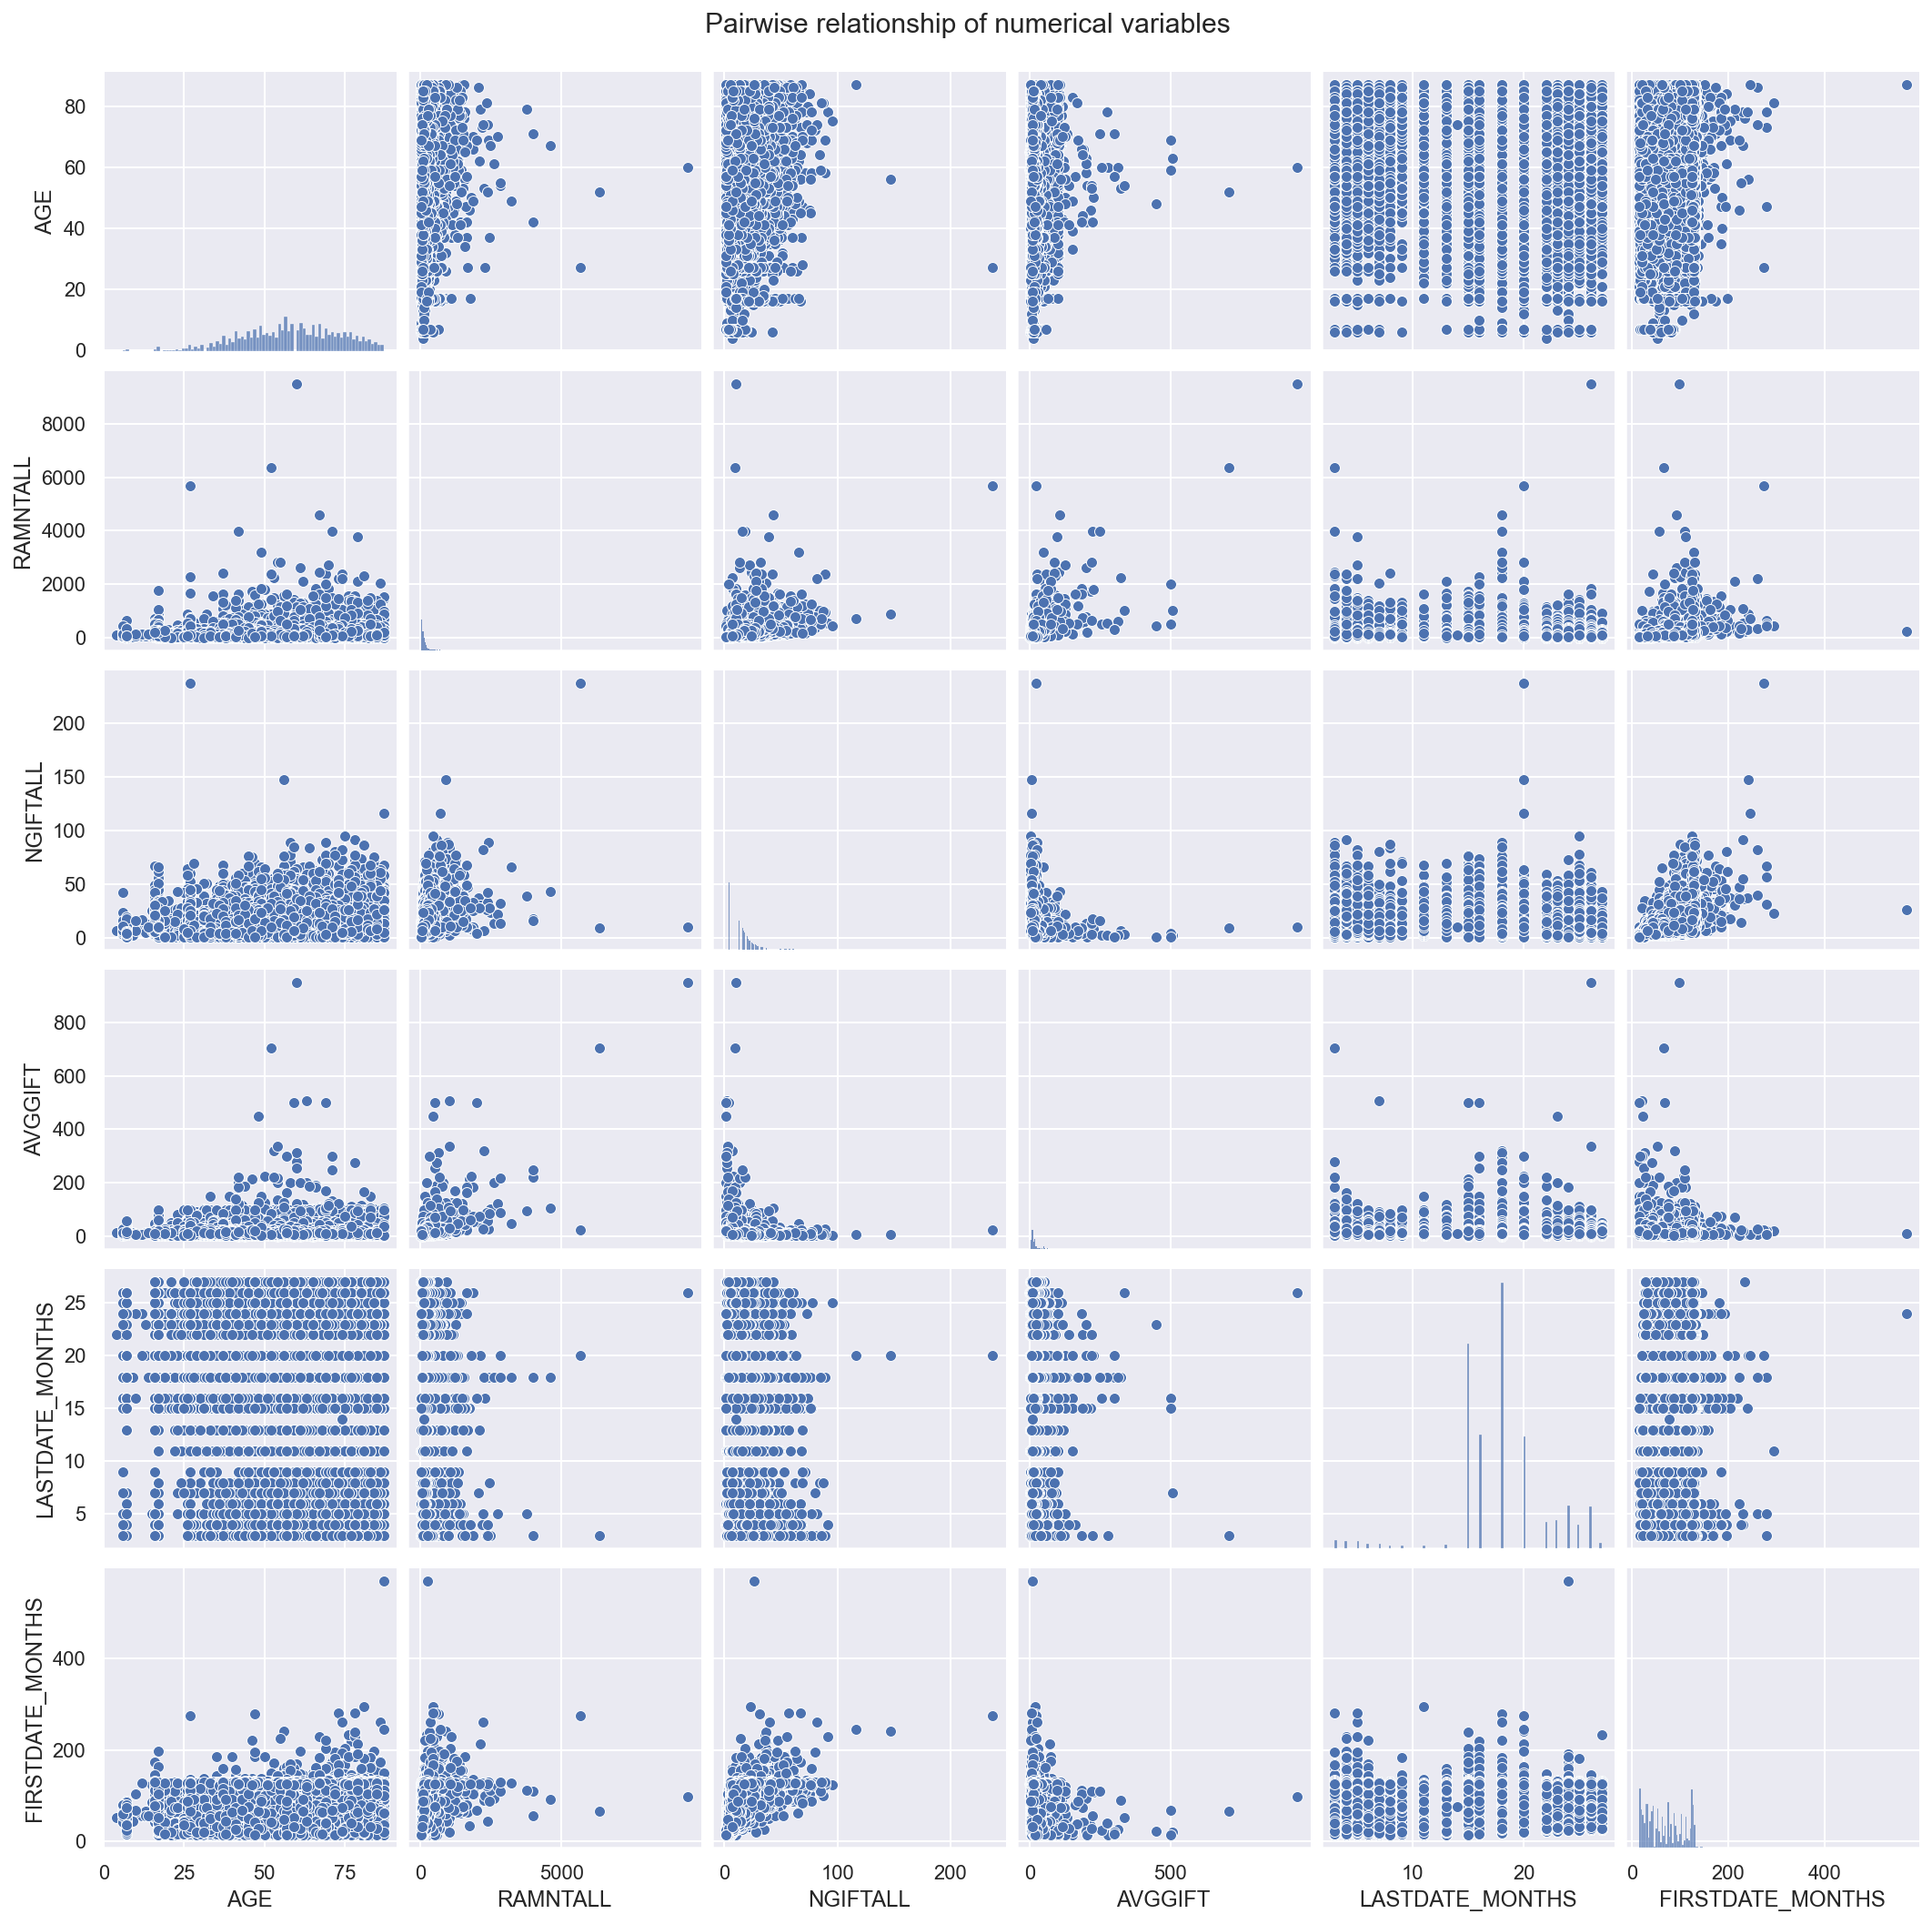

Executing shutdown due to inactivity...


2020-12-29 00:10:39,486 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2020-12-29 00:10:39,501 - INFO     - Executing shutdown...


In [62]:
# pairwise relationship of numerical Variables
sns.set()

# set pairplot and layout
sns.pairplot(data_fin[metric_features], diag_kind="hist")
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of numerical variables", fontsize=15)

plt.show()

#### Metric variables correlation

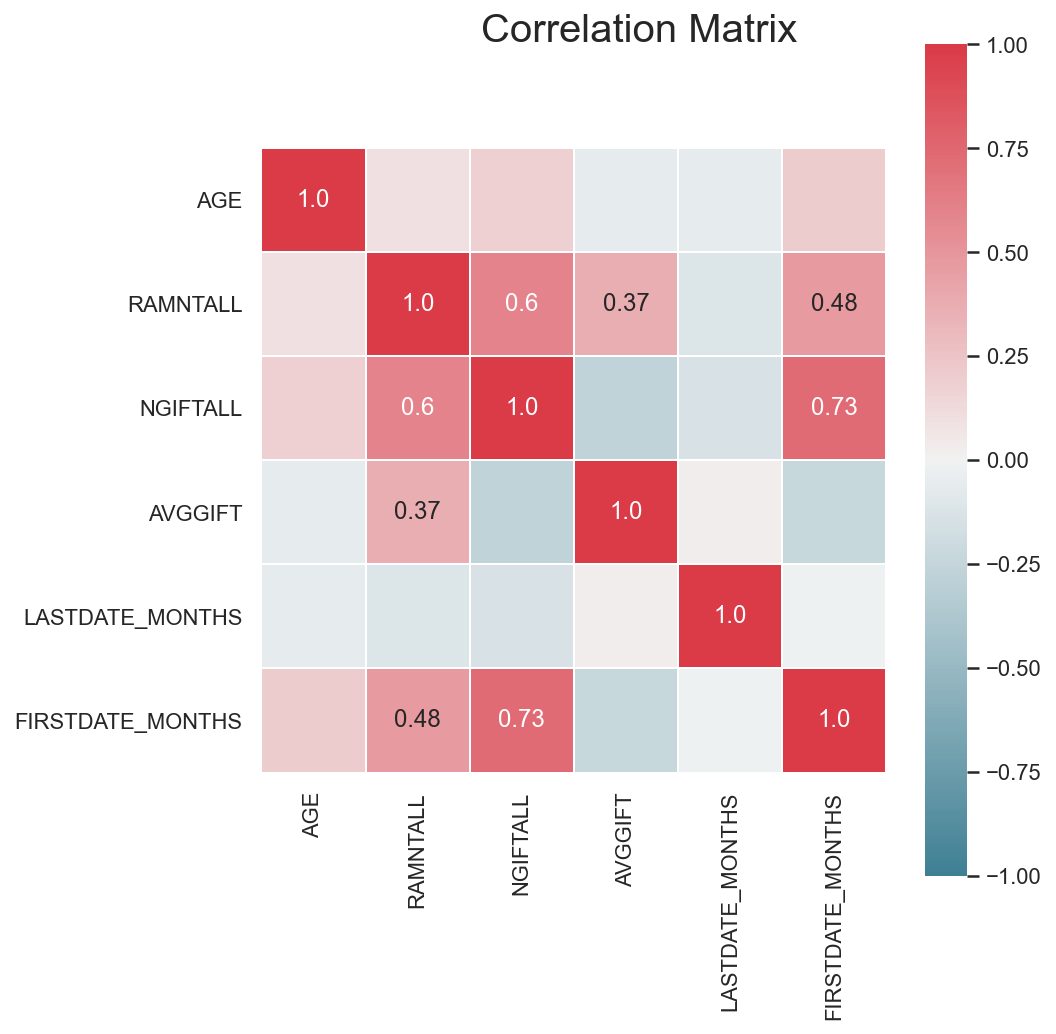

In [67]:
# Prepare figure
fig = plt.figure(figsize=(7, 7))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data_fin[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.3| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)
plt.show()

We see highest correlation between NGIFTALL and FIRSTDATE_MONTHS 
(a bit obvious - the earlier people joined - more times they donated)

#### Categorical variables association

In [51]:
# Cramer's V - implemetation was taken from link - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [52]:
# To get information about so-correlated categorical variables
# we build Correlation matrix based on Cramer's V for all categorical variables 
rows = []
cat_features = ['cat_FAD_domain', 'STATE', 'INCOME', 'WEALTH2', 'GENDER', 'RECENCY', 'AMOUNT']
dataframe = data_fin[cat_features].copy()

for var1 in dataframe:
    col = []
    for var2 in dataframe :
        cramers =cramers_v(dataframe[var1], dataframe[var2]) # Cramer's V
        col.append(round(cramers,3)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_array = np.array(rows)
dataframe = pd.DataFrame(cramers_array, columns = dataframe.columns, index = dataframe.columns)

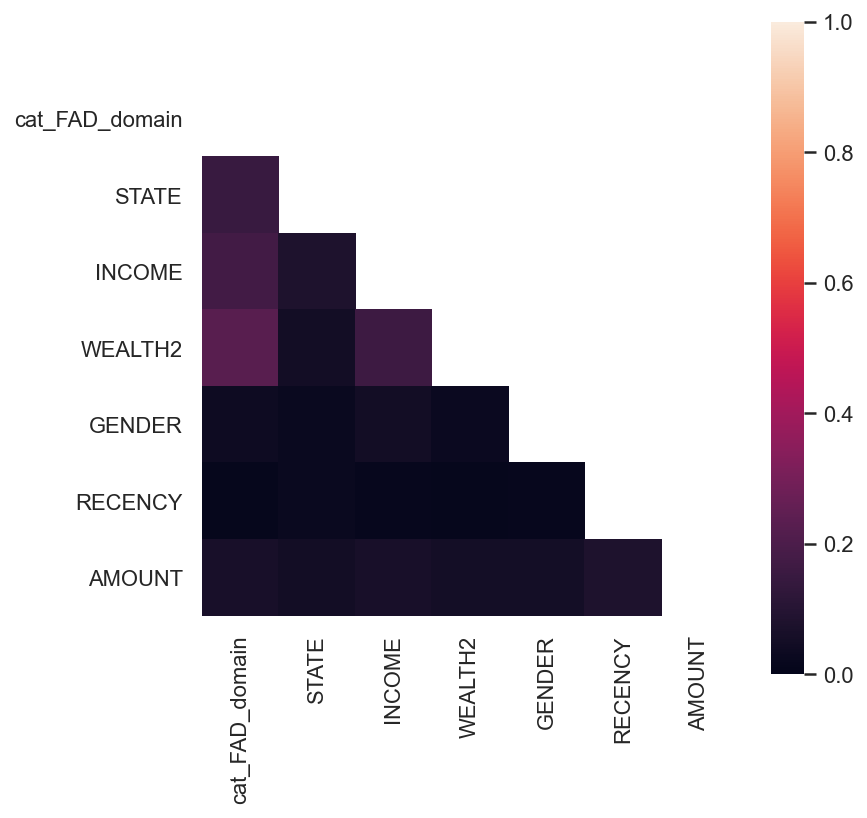

In [53]:
# Build heatmap plot to visualize association matrix for categorical features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
mask = np.zeros_like(dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(dataframe, mask = mask, vmin = 0., vmax=1, square=True)

plt.show()

#### PCA for Census data 

In [152]:
pca_features = ['AGEC6', 'HHD7', 'HHD11', 'LFC3', 'LFC4', 'LFC5', 
                'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7', 'EC8' ]

In [153]:
# Scale metric variables and variables chosen for PCA
scaler = StandardScaler()
pca_columns = data[pca_features].copy()



pca_columns = pd.DataFrame(scaler.fit_transform(pca_columns),
                           columns = pca_columns.columns,
                           index = pca_columns.index)
data_fin[metric_features] = pd.DataFrame(scaler.fit_transform(data_fin[metric_features]),
                           columns = data_fin[metric_features].columns,
                           index = data_fin[metric_features].index)

In [154]:
# Print normalized PCA columns
pca_columns

,AGEC6,HHD7,HHD11,LFC3,LFC4,LFC5,EC2,EC3,EC4,EC5,EC6,EC7,EC8
0,0.076568,-0.354471,-0.417101,-0.442595,-0.392213,-0.656144,0.873613,-0.374842,1.000212,0.027784,0.426383,-1.035283,-0.618552
1,-1.092023,-0.731600,-1.595278,0.141145,0.747168,0.292063,-0.455339,-1.032706,-1.634836,0.027784,0.132215,1.638585,1.793472
2,-0.090373,-0.165907,-0.202887,0.214113,0.009921,0.219124,1.598495,0.940887,-0.073326,-0.675346,-0.161954,-0.932442,-0.618552
3,-0.591198,-0.354471,-0.738422,-0.223693,-0.124124,-0.583205,2.323378,-0.111696,-1.439647,0.871540,1.014719,-1.138124,-0.334785
4,0.243510,2.285432,0.439755,-0.369628,-0.325191,-0.291449,0.873613,0.940887,0.121863,-1.097224,-1.044458,-0.212554,-0.334785
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,-1.258965,0.776916,-0.417101,1.235659,0.881213,1.167331,-0.817780,-0.769560,-0.073326,1.715296,0.426383,0.095969,0.090867
93363,-1.092023,-1.108729,-1.488171,-0.004790,1.149302,-0.072632,-0.938594,-0.901133,-1.634836,0.449662,0.132215,2.255632,0.942169
93364,-0.257315,1.531174,0.118434,0.943789,0.009921,1.167331,-0.455339,-1.295852,2.171344,0.309036,0.132215,-0.315395,-1.044204
93365,-0.591198,0.022658,-0.738422,0.287080,1.015258,0.292063,-0.213712,-0.901133,-0.854081,1.996548,1.603056,0.095969,-0.334785


In [155]:
pca = PCA()
pca_feat = pca.fit_transform(pca_columns)

In [156]:
pd.DataFrame(pca_columns.values @ pca.components_.T, 
             index=pca_columns.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)])

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,1.229230,-0.354019,-0.984593,-0.687497,0.082377,0.505255,-0.561440,0.339789,-0.738562,0.060609,0.484727,-0.226863,0.141877
1,-2.837532,1.138767,1.343151,-1.764001,0.271681,-0.020729,-0.084022,-0.533287,0.100432,-0.233004,0.110944,-0.299724,-0.077838
2,1.294051,-1.138463,0.609932,-0.225549,-0.386620,0.587517,-1.008136,-0.385532,0.336447,0.348104,0.245396,0.051304,-0.024873
3,0.512757,-0.404120,0.502596,-0.726813,1.664456,0.901030,-2.449830,-0.320040,-0.263024,0.275356,1.002778,-0.121703,0.216712
4,2.035552,-0.830684,1.634460,0.689069,0.220790,-0.414330,0.908922,-0.361580,-0.608173,-0.123332,-0.540688,0.232774,-0.172846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,-2.456935,-1.479421,-0.317714,0.301780,0.847557,-0.965094,0.016380,0.379443,-0.318499,0.117496,0.331177,-0.017781,0.003664
93363,-3.031438,1.282531,0.760139,-1.720516,0.390294,-0.284158,-0.409188,-0.292098,0.489023,-0.822026,-0.797961,-0.321566,0.101140
93364,-0.415545,-2.037935,-1.190216,0.605967,-0.329027,-0.480328,1.107956,1.001969,-1.773087,0.704991,-0.459059,0.072000,-0.213146
93365,-2.096431,-0.555150,-0.934039,-0.113246,1.782872,0.120059,-1.115936,-0.110799,-0.327842,-0.410454,0.164775,0.126437,-0.003923


In [157]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,4.653096,0.000000,0.357927,0.357927
2,2.512183,-2.140914,0.193243,0.551169
3,1.288395,-1.223788,0.099106,0.650276
4,1.076649,-0.211745,0.082818,0.733094
5,0.895184,-0.181465,0.068860,0.801953
6,0.700412,-0.194772,0.053877,0.855831
7,0.472446,-0.227967,0.036342,0.892172
8,0.422127,-0.050318,0.032471,0.924643
9,0.352648,-0.069479,0.027126,0.951770
10,0.293040,-0.059608,0.022541,0.974311


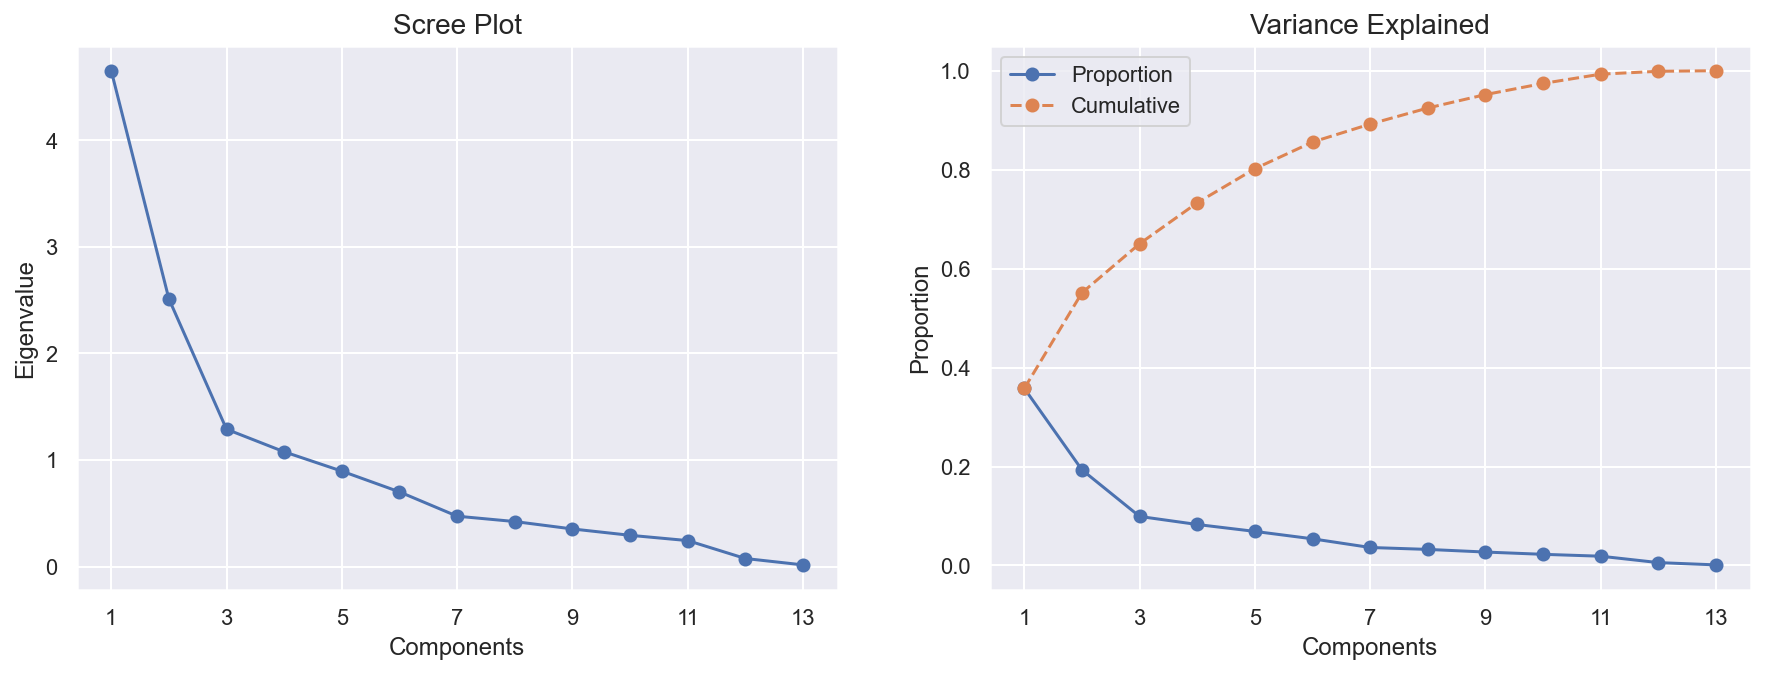

In [158]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

From graphs we see that number between 3-7 is ok to choose

Using Kaiser’s Criterion, where PCs with an eigenvector greater than 1.0 should be retained we need to leave first 4 PCs.
https://en.wikipedia.org/wiki/Factor_analysis#Older_methods


In [146]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components = 4)
pca_feat = pca.fit_transform(pca_columns)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=pca_columns.index, columns=pca_feat_names)  
pca_df

,PC0,PC1,PC2,PC3
0,1.229230,-0.354019,-0.984593,-0.687497
1,-2.837532,1.138767,1.343151,-1.764001
2,1.294051,-1.138463,0.609932,-0.225549
3,0.512757,-0.404120,0.502596,-0.726813
4,2.035552,-0.830684,1.634460,0.689069
...,...,...,...,...
93362,-2.456935,-1.479421,-0.317714,0.301780
93363,-3.031438,1.282531,0.760139,-1.720516
93364,-0.415545,-2.037935,-1.190216,0.605967
93365,-2.096431,-0.555150,-0.934039,-0.113246


In [147]:
# Merge data_fin with pca variables to check their relationship
df_pca = pd.concat([data_fin, pca_columns, pca_df], axis=1)
df_pca.head()

,cat_FAD_domain,STATE,AGE,INCOME,WEALTH2,GENDER,RECENCY,FREQUENCY,AMOUNT,RAMNTALL,...,EC3,EC4,EC5,EC6,EC7,EC8,PC0,PC1,PC2,PC3
0,T2,IL,0.034385,6,5,0,L,4,E,1.148089,...,-0.374842,1.000212,0.027784,0.426383,-1.035283,-0.618552,1.229230,-0.354019,-0.984593,-0.687497
1,S1,CA,-0.904638,6,9,1,L,2,G,-0.485953,...,-1.032706,-1.634836,0.027784,0.132215,1.638585,1.793472,-2.837532,1.138767,1.343151,-1.764001
2,R2,NC,-0.166834,3,1,1,L,4,E,0.826361,...,0.940887,-0.073326,-0.675346,-0.161954,-0.932442,-0.618552,1.294051,-1.138463,0.609932,-0.225549
3,R2,CA,0.705116,1,0,0,L,4,E,0.038973,...,-0.111696,-1.439647,0.871540,1.014719,-1.138124,-0.334785,0.512757,-0.404120,0.502596,-0.726813
4,S2,FL,1.241701,3,4,0,L,2,F,1.266621,...,0.940887,0.121863,-1.097224,-1.044458,-0.212554,-0.334785,2.035552,-0.830684,1.634460,0.689069


In [149]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_features + pca_feat_names].corr().loc[metric_features + pca_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3
AGE,0.118126,0.151700,-0.050228,0.099163
RAMNTALL,0.001632,0.055369,-0.015978,0.015564
NGIFTALL,0.068443,0.015962,-0.052720,0.023674
AVGGIFT,-0.070468,0.048687,0.043182,-0.006416
LASTDATE_MONTHS,-0.005015,-0.026955,0.007998,-0.022184
FIRSTDATE_MONTHS,0.057894,0.038458,-0.053397,0.019644
AGEC6,0.471628,0.535459,-0.394311,0.309864
HHD7,0.288479,-0.560141,0.373256,0.281320
HHD11,0.209478,0.311165,0.130661,0.842339
LFC3,-0.725787,-0.581368,0.062349,0.188707


In [159]:
# Merge data_fin with pca variables
data_fin = pd.concat([data_fin, pca_df], axis=1)
data_fin

,cat_FAD_domain,STATE,AGE,INCOME,WEALTH2,GENDER,RECENCY,FREQUENCY,AMOUNT,RAMNTALL,NGIFTALL,LASTGIFT,AVGGIFT,LASTDATE_MONTHS,FIRSTDATE_MONTHS,PC0,PC1,PC2,PC3
0,T2,IL,0.034385,6,5,0,L,4,E,1.148089,2.505245,10.0,-0.544641,0.018256,0.595027,1.229230,-0.354019,-0.984593,-0.687497
1,S1,CA,-0.904638,6,9,1,L,2,G,-0.485953,-0.771696,25.0,0.227888,0.018256,-0.655840,-2.837532,1.138767,1.343151,-1.764001
2,R2,NC,-0.166834,3,1,1,L,4,E,0.826361,2.037111,5.0,-0.570031,0.018256,0.541799,1.294051,-1.138463,0.609932,-0.225549
3,R2,CA,0.705116,1,0,0,L,4,E,0.038973,0.749741,10.0,-0.635246,0.018256,1.473296,0.512757,-0.404120,0.502596,-0.726813
4,S2,FL,1.241701,3,4,0,L,2,F,1.266621,3.207447,15.0,-0.630141,-0.462484,4.028259,2.035552,-0.830684,1.634460,0.689069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,C2,AK,-0.099761,1,4,1,L,1,G,-0.672216,-1.005763,25.0,1.137732,-0.702854,-1.401038,-2.456935,-1.479421,-0.317714,0.301780
93363,C1,TX,-0.770492,7,9,1,L,1,F,-0.714549,-1.005763,20.0,0.650315,-0.702854,-1.401038,-3.031438,1.282531,0.760139,-1.720516
93364,C3,MI,0.034385,5,8,1,A,3,E,-0.392821,-0.303561,10.0,-0.491632,-2.625811,-0.948597,-0.415545,-2.037935,-1.190216,0.605967
93365,C1,CA,-0.099761,7,7,0,A,4,F,3.332457,3.675581,18.0,-0.115285,-3.346920,1.526524,-2.096431,-0.555150,-0.934039,-0.113246


In [54]:
# mca_features = ['cat_FAD_domain', 'STATE', 'INCOME', 'WEALTH2']
# mca_data = data_fin[mca_features]
# mca = MCA(n_iter=3, copy=True, check_input=True, engine='auto', random_state=42)
# mca.fit(mca_data)
# data_mca = mca.transform(mca_data)
# data_mca.head()

In [55]:
#mca.explained_inertia_
# DIDN"T WORK OUT

#### TCODE column that was chosen in the beginning to work with and was dropped after some EDA:

Checking for inconsistencies in TCODE, that we were going to use as a source of information

In [57]:
dictTCODE = {
    "0" : "_",
    "1" : "MR.",
    "1001" : "MESSRS.",
    "1002" : "MR. & MRS.",
    "2" : "MRS.",
    "2002" : "MESDAMES",
    "3" : "MISS",
    "3003" : "MISSES",
    "4" : "DR.",
    "4002" : "DR. & MRS.",
    "4004" : "DOCTORS",
    "5" : "MADAME",
    "6" : "SERGEANT",
    "9" : "RABBI",
    "10" : "PROFESSOR",
    "10002" : "PROFESSOR & MRS.",
    "10010" : "PROFESSORS",
    "11" : "ADMIRAL",
    "11002" : "ADMIRAL & MRS.",
    "12" : "GENERAL",
    "12002" : "GENERAL & MRS.",
    "13" : "COLONEL",
    "13002" : "COLONEL & MRS.",
    "14" : "CAPTAIN",
    "14002" : "CAPTAIN & MRS.",
    "15" : "COMMANDER",
    "15002" : "COMMANDER & MRS.",
    "16" : "DEAN",
    "17" : "JUDGE",
    "17002" : "JUDGE & MRS.",
    "18" : "MAJOR",
    "18002" : "MAJOR & MRS.",
    "19" : "SENATOR",
    "20" : "GOVERNOR",
    "21002" : "SERGEANT & MRS.",
    "22002" : "COLONEL & MRS.", #mistype in COLONEL, was changed here
    "24002" : "LIEUTENANT & MRS.", #XX002 code is used for someone & MRS.
    "24" : "LIEUTENANT",
    "26" : "MONSIGNOR",
    "27" : "REVEREND",
    "28" : "MS.",
    "28028" : "MSS.",
    "29" : "BISHOP",
    "31" : "AMBASSADOR",
    "31002" : "AMBASSADOR & MRS.",
    "33" : "CANTOR",
    "36" : "BROTHER",
    "37" : "SIR",
    "38" : "COMMODORE",
    "40" : "FATHER",
    "42" : "SISTER",
    "43" : "PRESIDENT",
    "44" : "MASTER",
    "46" : "MOTHER",
    "47" : "CHAPLAIN",
    "48" : "CORPORAL",
    "50" : "ELDER",
    "56" : "MAYOR",
    "59002" : "LIEUTENANT & MRS.",
    "62" : "LORD",
    "63" : "CARDINAL",
    "64" : "FRIEND",
    "65" : "FRIENDS",
    "68" : "ARCHDEACON",
    "69" : "CANON",
    "70" : "BISHOP",
    "72002" : "REVEREND & MRS.",
    "73" : "PASTOR",
    "75" : "ARCHBISHOP",
    "85" : "SPECIALIST",
    "87" : "PRIVATE",
    "89" : "SEAMAN", 
    "90" : "AIRMAN",
    "91" : "JUSTICE",
    "92" : "MR. JUSTICE",
    "100" : "M.",
    "103" : "MLLE.",
    "104" : "CHANCELLOR",
    "106" : "REPRESENTATIVE",
    "107" : "SECRETARY",
    "108" : "LT. GOVERNOR",
    "109" : "LIC.",
    "111" : "SA.",
    "114" : "DA.",
    "116" : "MR.", #Changed SR ro MR
    "117" : "MRS.", #Changed SRA ro MRS
    "118" : "MISS", #Cnanged SRTA. to MISS
    "120" : "YOUR MAJESTY",
    "122" : "HIS HIGHNESS",
    "123" : "HER HIGHNESS",
    "124" : "COUNT",
    "125" : "LADY",
    "126" : "PRINCE",
    "127" : "PRINCESS",
    "128" : "CHIEF",
    "129" : "BARON",
    "130" : "SHEIK",
    "131" : "PRINCE AND PRINCESS",
    "132" : "YOUR IMPERIAL MAJEST",
    "135" : "M. ET MME.",
    "210" : "PROF.",
    '72': 'REVEREND', #because code 72002 REVEREND AND MRS, I think it was 072 and 027 for REVEREND 
    #because some systematic mistake (mistype), and in the end someone changed it in system
    '22': "COLONEL & MRS.", #just a mistype,
    
}

In [58]:
data['TCODE'] = data['TCODE'].apply(str)

data["cat_TCODE"] = data.TCODE.replace(to_replace=dictTCODE)

After checking for inconsistancies in the TCODE we are going to drop this column

In [59]:
# CHECKING FOR INCONSISTENCIES IN TCODE
# even after droping some amount of data
print('Number of Men(GENDER M) with title MRS.(Mrs - womans title of married woman)', 
      len(data[(data.GENDER == 1)&(data.cat_TCODE == 'MRS.')]))
print('Number of men with title MISS (title of young or unmarried woman)', 
      len(data[(data.GENDER == 1)&(data.cat_TCODE == 'MISS')]))
print('Number of men with title MS. (title of married or not married woman)', 
      len(data[(data.GENDER == 1)&(data.cat_TCODE == 'MS.')]))
print('Number of women with title MR. (stays for mister, mans title)', 
      len(data[(data.GENDER == 2)&(data.cat_TCODE == 'MR.')]))
print('Number of men with title Sister', 
      len(data[(data.GENDER == 1)&(data.cat_TCODE == 'SISTER')]))
print('Number of women with title Brother', 
      len(data[(data.GENDER == 2)&(data.cat_TCODE == 'BROTHER')]))
print('Number of women with title MR. & MRS., that implies that they should be men',
      len(data[(data.GENDER == 2)&(data.cat_TCODE == 'MR. & MRS.')]))

Number of Men(GENDER M) with title MRS.(Mrs - womans title of married woman) 3388
Number of men with title MISS (title of young or unmarried woman) 34
Number of men with title MS. (title of married or not married woman) 216
Number of women with title MR. (stays for mister, mans title) 0
Number of men with title Sister 1
Number of women with title Brother 0
Number of women with title MR. & MRS., that implies that they should be men 0
